# LightSB Trained on the Latents from AutoencoderKL

## Imports

In [27]:
import os, sys
from tqdm import tqdm
import numpy as np
np.random.seed(0)


import diffusers
import torch

import matplotlib.pyplot as plt
from diffusers import AutoencoderKL

LightSB_DIR = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "models", "LightSB")
sys.path.append(LightSB_DIR)

from src.light_sb import LightSB
from src.distributions import TensorSampler

## Light Schrödinger Bridge Config

In [ ]:
DIM = 4096

INPUT_DATA = "night"
TARGET_DATA = "daytime"

# CONFIGS FROM LightSB_alae.ipynb
OUTPUT_SEED = 0xBADBEEF
BATCH_SIZE = 128
EPSILON = 0.1
D_LR = 1e-3 # 1e-3 for eps 0.1
D_GRADIENT_MAX_NORM = float("inf")
N_POTENTIALS = 10
SAMPLING_BATCH_SIZE = 128
INIT_BY_SAMPLES = True
IS_DIAGONAL = True

MAX_STEPS = 10000
CONTINUE = -1

In [29]:
EXP_NAME = f'LightSB_AUTOENCODERKL_{INPUT_DATA}_TO_{TARGET_DATA}_EPSILON_{EPSILON}'
OUTPUT_PATH = '../checkpoints/{}'.format(EXP_NAME)

config = dict(
    DIM=DIM,
    D_LR=D_LR,
    BATCH_SIZE=BATCH_SIZE,
    EPSILON=EPSILON,
    D_GRADIENT_MAX_NORM=D_GRADIENT_MAX_NORM,
    N_POTENTIALS=N_POTENTIALS,
    INIT_BY_SAMPLES=INIT_BY_SAMPLES,
    IS_DIAGONAL=IS_DIAGONAL,
)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [30]:
# CUDA -> MPS -> CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)

mps


## Data

In [31]:
train_day = np.load('../../data/encodings/train_day_latents.npy')
train_night = np.load('../../data/encodings/train_night_latents.npy')

val_day = np.load('../../data/encodings/val_day_latents.npy')
val_night = np.load('../../data/encodings/val_night_latents.npy')

print("train_day shape: ", train_day.shape)
print("train_night shape: ",train_night.shape)
print("val_day shape: ",val_day.shape)
print("val_night shape: ",val_night.shape)

print(train_day[0].shape)

train_day shape:  (36800, 4096)
train_night shape:  (28028, 4096)
val_day shape:  (5258, 4096)
val_night shape:  (3929, 4096)
(4096,)


In [32]:
# X -> Y, so night -> day
# Like LightSB_ALAE
X_train = torch.tensor(train_night, device=device)
Y_train = torch.tensor(train_day, device=device)

X_test = torch.tensor(val_night, device=device)
Y_test = torch.tensor(val_day, device=device)

X_sampler = TensorSampler(X_train, device=device)
Y_sampler = TensorSampler(Y_train, device=device)

## Models

### AutoencoderKL

In [33]:
# source: https://huggingface.co/docs/diffusers/api/models/autoencoderkl
url = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/blob/main/vae-ft-mse-840000-ema-pruned.safetensors"  # can also be a local file
model = AutoencoderKL.from_single_file(url)
model = model.to(device)

# no training, so set to eval mode
model.eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

### LightSB

In [34]:
# Like LightSB_ALAE
torch.manual_seed(OUTPUT_SEED); np.random.seed(OUTPUT_SEED)

D = LightSB(dim=DIM, n_potentials=N_POTENTIALS, epsilon=EPSILON,
            sampling_batch_size=SAMPLING_BATCH_SIZE, S_diagonal_init=0.1,
            is_diagonal=IS_DIAGONAL).to(device)

if INIT_BY_SAMPLES:
    D.init_r_by_samples(Y_sampler.sample(N_POTENTIALS))
    
D_opt = torch.optim.Adam(D.parameters(), lr=D_LR)

## Training

In [35]:
for step in tqdm(range(CONTINUE + 1, MAX_STEPS)):
    D_opt.zero_grad()
    
    X0, X1 = X_sampler.sample(BATCH_SIZE), Y_sampler.sample(BATCH_SIZE)
    
    log_potential = D.get_log_potential(X1)
    log_C = D.get_log_C(X0)
    
    D_loss = (-log_potential + log_C).mean()
    D_loss.backward()
    D_gradient_norm = torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=D_GRADIENT_MAX_NORM)
    D_opt.step()
         
torch.save(D.state_dict(), os.path.join(OUTPUT_PATH, f'D.pt'))
torch.save(D_opt.state_dict(), os.path.join(OUTPUT_PATH, f'D_opt.pt'))

  0%|          | 0/10000 [00:00<?, ?it/s]


NotImplementedError: The operator 'aten::linalg_matrix_exp' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

## YOLOPX

## Plots

### Prior to Training

In [ ]:
def reconstruct_img(latent, encoder):
    encoding = torch.as_tensor(latent, device=device).reshape([1,4,32,32])
    return encoder.decode(encoding)

def get_decoded_img(latent, encoder):
    decoded = reconstruct_img(latent, encoder)
    return diffusers.utils.pt_to_pil(decoded.sample.detach().cpu())[0]

def get_samples(latents,encoder, how_many=5, decode=False):
    indexes = np.random.choice(latents.shape[0], how_many)
    images = []
    for index in indexes:
        img = get_decoded_img(latents[index], encoder)
        images.append(img)
    return images

def plot_samples(images, title=""):
    length = len(images)

    plt.figure(figsize=(10,10*length))
    plt.title(title)
    for i, image in enumerate(images):
        plt.subplot(1,length,i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()


/var/folders/fc/0ydf8wkd1fsdr1whhc_nx6j80000gn/T/ipykernel_73512/2193175751.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,length,i+1)


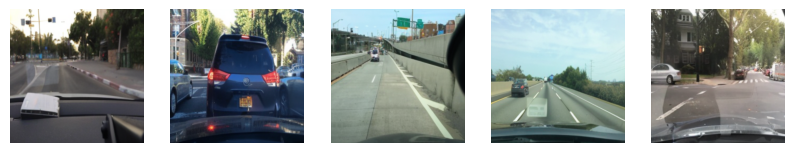

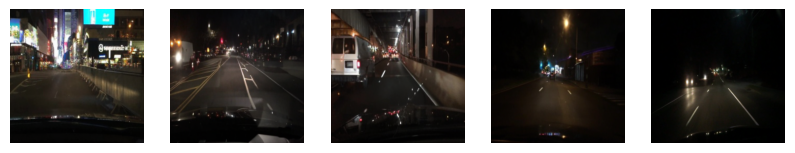

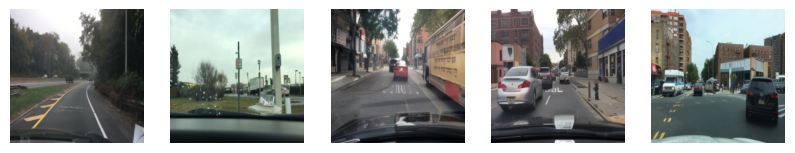

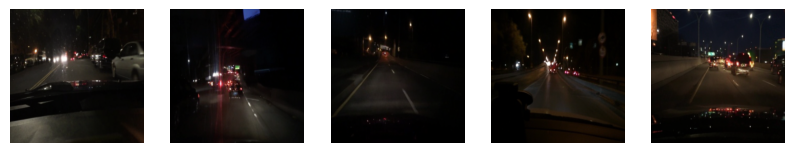

In [ ]:
td_samples = get_samples(train_day, model)
tn_samples= get_samples(train_night, model)

vd_samples = get_samples(val_day, model)
vn_samples= get_samples(val_night, model)

plot_samples(td_samples, "Train Day Samples")
plot_samples(tn_samples, "Train Night Samples")
plot_samples(vd_samples, "Val Day Samples")
plot_samples(vn_samples, "Val Night Samples")

### After training

In [ ]:
print(device)

mps


/var/folders/fc/0ydf8wkd1fsdr1whhc_nx6j80000gn/T/ipykernel_73512/2193175751.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,length,i+1)


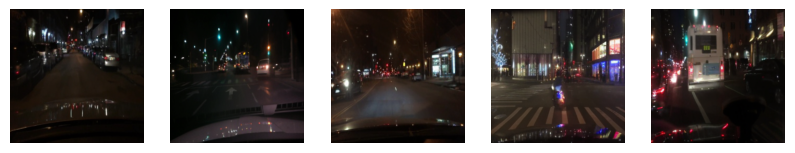

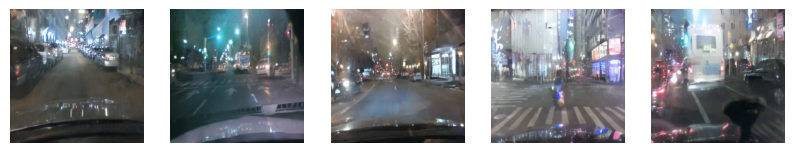

In [ ]:
indexes = np.random.choice(X_test.shape[0], 5)
samples = X_test[indexes]

before_translation = []
with torch.no_grad():
    for sample in samples:
        before = get_decoded_img(sample, model)
        before_translation.append(before)

plot_samples(before_translation)

with torch.no_grad():
    transformed = D(samples)
    
# decode these using AutoencoderKL
decoded = []
with torch.no_grad():
    for sample in transformed:
        decoded_img = get_decoded_img(sample, model)
        decoded.append(decoded_img)

plot_samples(decoded)